## Vector Quantization Classifier
### Written by David Terpay
Build a classifier that classifies the given files into the appropriate activity ('Use_telephone', 'Standup_chair', 'Walk', 'Climb_stairs', 'Sitdown_chair', 'Brush_teeth', 'Comb_hair', 'Eat_soup', 'Pour_water', 'Descend_stairs', 'Eat_meat', 'Drink_glass', 'Getup_bed', 'Liedown_bed').

The data items in this case are the files themselves; the classifier you learn will be able to take an activity file of arbitrary length and classify it with one of the activity labels. You might notice that each file is of a different length, which is why we will use vector quantization to turn each file into a fixed-length feature vector.

For your classifier's features, you should use vector quantization, creating a histogram of cluster centers for each data item. You should use k-means in order to construct the pattern vocabulary. You may use whichever multi-class classifier you wish.

Please hand in the following

Report your total error rate and the class confusion matrix for your classifier.
Then, improve your classifier by a) modifying the number of cluster centers in your k-means and b) modifying the size of the fixed length samples that you use.

### Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import os, sys
import csv
from sklearn.cluster import KMeans
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
%matplotlib inline

### Parsing and reading the data

We will store the integer labels for each activity and its corresponding directory in list_data_ints. We will additionally store all of the pathways for each of the files in list_data_files

In [2]:
list_data_ints = []
list_data_files = []

#path to determine where to read directory
path = '/Users/davidterpay/Desktop/UIUC/CS 361/Final/HMP_Dataset/'
dirs = os.listdir(path)
dirs.remove('.DS_Store')
dirs.remove('.ipynb_checkpoints')
row = 0
ctr = 0
#reading the data
for file in dirs:
    folder = os.listdir(path + '/' + file)
    #changing directory
    os.chdir(path + file)
    for data in folder:
        list_data_ints.append(ctr)
        list_data_files.append(path + file + '/' + data)
    ctr += 1
    #changing directory
    os.chdir(path)
    


### Spliting the data into training and testing data
Using sklearns sklearn.model_selection package we will efficiently randomize the data and select proper test size.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(list_data_files,list_data_ints,test_size=0.2,random_state = 100)

### Member functions

#### get_vec()
This function will read in the data from a given file and will store of the data in x,y,z coordinates etc. This is a helper function to fully_extract.

#### fully_extract()
This function is an abstract function that will read in all of the files from list and will convert them all into a more practical format.

#### make_vec()
This function is a function that will create a fixed length vector of any given size. We do this to allow vector quantization to happen if our files are of different lengths. This is a helper function.

#### total_vec()
This function is an abstract function that will create fixed length vectors of all of the vectors in a given file.

#### split_file_data()
This function allows us to use prediction with k-means later on. It simply finds all fixed length vectors in a given file and puts them into a list.

#### features()
This function produces the features of our dataset. This will allow us to apply k-means and then push all of our features onto any classifier we want.

In [4]:
def get_vec(filepath):
    data = []
    with open(filepath, "rt") as file:
            for line in file:
                list_of_nums = [int(x) for x in line.split()]
                data.append(list_of_nums)
    return data

def fully_extract(files):
    test_data = []
    for name in files:
        test_data.append(get_vec(name))
    return test_data
    
def make_vec(array,size):
    counter = len(array) // size
    total_vec = []
    up_bound = size
    lower_bound= 0
    for i in range(0,counter * size,size):
        temp = array[lower_bound:up_bound]
        lower_bound += size
        up_bound += size
        temp = np.asarray(temp)
        total_vec.append(temp.transpose().flatten())
    return total_vec

def total_vec(data,size):
    total_data = []
    for i in range(len(data)):
        for row in make_vec(data[i],size):
            total_data.append(row)
    return total_data

def split_file_data(data,size):
    total_data = []
    for i in range(len(data)):
        total_data.append(make_vec(data[i],size))
    return total_data

def features(array,dataset,clusters):
    kmeans = KMeans(n_clusters=clusters,random_state=100)
    kmeans.fit(dataset)
    features = []
    for file in array:
        feature = []
        temp_vec = kmeans.predict(file)
        for i in range(clusters):
            frequency = (temp_vec == i).sum()
            if frequency != 0:
                feature.append(frequency)
            else:
                feature.append(0)
        features.append(feature)
    return features

### Let us denote training data here

In [5]:
#first find all of the vectors
data_total_training = fully_extract(X_train)
#merge all of the vectors together
clean_data_total_training = total_vec(data_total_training,32)
#split all of the vectors by file
split_file = split_file_data(data_total_training,32)

### Let us denote our testing data here


In [6]:
#first find all of the vectors
test_total_all = fully_extract(X_test)
#merge all of the vectors together
test_data_total_combined = total_vec(test_total_all,32)
#split all of the vectors by file
split_file_test = split_file_data(test_total_all,32)

### We will use SVC as our classifier

In [8]:
clf = SVC()
training_feature = features(split_file,clean_data_total_training,50)
clf.fit(training_feature, y_train)

test_features = features(split_file_test, clean_data_total_training,50)
predicted_labels = clf.predict(test_features)

# Accuracy/Error rate for 50 clusters and a fixed vector length of 32

In [9]:
print("The accuracy score of this SVC is", metrics.accuracy_score(y_test,predicted_labels))
print("The error rate of this SVC is", str(1 - metrics.accuracy_score(y_test,predicted_labels)))

The accuracy score of this SVC is 0.744047619048
The error rate of this SVC is 0.255952380952


# Confusion Matrix for 50 clusters and a fixed vector length of 32

In [10]:
print("The confusion matrix of the SVC is")
metrics.confusion_matrix(y_test,predicted_labels)

The confusion matrix of the SVC is


array([[ 0,  0,  2,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0],
       [ 0,  1, 24,  0,  0,  1,  0,  1,  2,  0,  0,  0],
       [ 0,  1,  0,  2,  0,  0,  0,  6,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 14,  0,  0,  7,  0,  0,  1],
       [ 0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 17,  0,  0,  1,  0],
       [ 0,  0,  2,  0,  0,  5,  0,  0, 15,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  2],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13]])

#### classify()
This is a wrapper function that allows you to input as many clusters as you want as well as controlling the size of the fixed length vector

In [11]:
def classify(clusters,vector_size):
    #first find all of the vectors
    data_total_training = fully_extract(X_train)
    #merge all of the vectors together
    clean_data_total_training = total_vec(data_total_training,vector_size)
    #split all of the vectors by file
    split_file = split_file_data(data_total_training,vector_size)
    #first find all of the vectors
    test_total_all = fully_extract(X_test)
    #merge all of the vectors together
    test_data_total_combined = total_vec(test_total_all,vector_size)
    #split all of the vectors by file
    split_file_test = split_file_data(test_total_all,vector_size)
    clf = SVC()
    training_feature = features(split_file,clean_data_total_training,clusters)
    clf.fit(training_feature, y_train)
    test_features = features(split_file_test, clean_data_total_training,clusters)
    predicted_labels = clf.predict(test_features)
    return metrics.accuracy_score(y_test,predicted_labels)

In [12]:
def graphing_clusters(low,clusters):
    x = []
    y = []
    for i in range(low,clusters):
        x.append(i)
        y.append(1 - classify(i,32))
    return x,y
x,y = graphing_clusters(1,50)

# Optimizing the Number of clusters

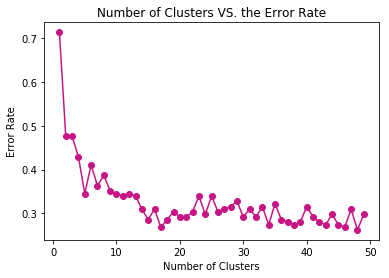

In [14]:
# plot with matplotlib
import matplotlib.pyplot as plt
plt.plot( x,y, marker='o', color='mediumvioletred')
plt.title("Number of Clusters VS. the Error Rate")
plt.xlabel("Number of Clusters")
plt.ylabel("Error Rate")
plt.show()

### It is clear from the graph that aroujnd 48-52 clusters will provide us with the smallest error rate. In the following portion where I test the optimal fixed vector length, I will use 50 clusters.

In [15]:
def graphing_vectors(low,high):
    x = []
    y = []
    for i in range(low,high):
        x.append(i)
        y.append(1 - classify(50,i))
    return x,y
x,y = graphing_vectors(1,50)

# Optimizing the Fixed Vector Length

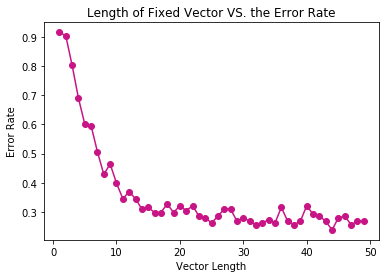

In [16]:
# plot with matplotlib
plt.plot( x,y, marker='o', color='mediumvioletred')
plt.title("Length of Fixed Vector VS. the Error Rate")
plt.xlabel("Vector Length")
plt.ylabel("Error Rate")
plt.show()

We generally want to select a low error rate in order to make our classifier be as accurate as possible. This point is usually known as the elbow or the knee. Based on both of the graphs mentioned above, it is clear that somewhere between 20-50 clusters and a vector size between 30-50 is optimal. Using 50 clusters and a fixed vector length of 44 we get total error rate to be...

In [17]:
print("The error rate is "+ str(1 - classify(50,44)))

The error rate is 0.238095238095
